## <a id='toc1_1_'></a>[Dataset Compilation & Partitioning (COMP)](#toc0_)

**Objective:** Build the MSH-Tanzania dataset and split it into development and test sets to prepare for model training and evaluation.

---

**Table of contents**<a id='toc0_'></a>    
- [Dataset Compilation & Partitioning (COMP)](#toc1_1_)    
  - [Imports](#toc1_2_)    
  - [Parameters](#toc1_3_)    
  - [Variables](#toc1_4_)    
  - [Creating folder for final dataset](#toc1_5_)    
  - [Loading data](#toc1_6_)    
  - [Splitting Data](#toc1_7_)    
    - [Saving class distribution with the splitting info](#toc1_7_1_)    
    - [Visualize splitting](#toc1_7_2_)    
    - [Sanity Check](#toc1_7_3_)    
  - [Saving images to the fine dataset folder](#toc1_8_)    
  - [Persist the data and info with DVC](#toc1_9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---

## <a id='toc1_2_'></a>[Imports](#toc0_)

In [28]:
import os, sys
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../../src/")
from utils import *


## <a id='toc1_3_'></a>[Parameters](#toc0_)

In [29]:
DATASET_NAME = 'MHS-Tanzania'                               # dataset name
DATASET_ROOT_DIR = "../../datasets/"                        # dataset dir
EXP_IMG_DIR = 'data/intermediate/images/'                   # images saved in the previous pipeline step (EXP)
DATA_FNAME = "data/processed/MSH-Tanzania_metadata_all.csv" # CSV with metadata
SPLIT_SEED = 42
TEST_SPLIT_SIZE = 0.2


## <a id='toc1_4_'></a>[Variables](#toc0_)

In [30]:
DATASET_DIR = os.path.join(DATASET_ROOT_DIR, DATASET_NAME)  # dir for saving the final dataset
DEV_IMG_DIR = os.path.join(DATASET_DIR, 'dev_images')
TEST_IMG_DIR = os.path.join(DATASET_DIR, 'test_images') 
REPORT_DIR = os.path.join(DATASET_DIR, 'report') 

## <a id='toc1_5_'></a>[Creating folder for final dataset](#toc0_)

In [31]:
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(DEV_IMG_DIR, exist_ok=True)
os.makedirs(TEST_IMG_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

## <a id='toc1_6_'></a>[Loading data](#toc0_)

In [32]:
data = pd.read_csv(DATA_FNAME)

## <a id='toc1_7_'></a>[Splitting Data](#toc0_)

In [33]:
data_distribution = data.value_counts(['sample_name']).reset_index(name='counts') 
data_distribution

,sample_name,counts
0,vitamin-c,636
1,paracetamol,326
2,benzyl-penicillin,317
3,penicillin-procaine,310
4,quinine,298
5,amoxicillin,296
6,lactose,225
7,cellulose,215
8,starch,214
9,paracetamol-starch,112


In [34]:
# Splitting the data into development (dev_set) and test (test_set) sets
dev_set, test_set = train_test_split(data, test_size=TEST_SPLIT_SIZE, stratify=data['sample_name'], random_state=SPLIT_SEED)

# Sort dev_set
dev_set = dev_set.sort_values(by=['sample_name', 'id', 'sample_id'], ascending=[True, False, False])
dev_set = dev_set.reset_index(drop=True)
dev_set.to_csv(f"{DATASET_DIR}/metadata_dev.csv", index=False)
dev_set['image_name'] = dev_set.apply(lambda x: create_filename(x), axis=1)


# Sort test_set
test_set = test_set.sort_values(by=['sample_name', 'id', 'sample_id'], ascending=[True, False, False])
test_set = test_set.reset_index(drop=True)
test_set.to_csv(f"{DATASET_DIR}/metadata_test.csv", index=False)
test_set['image_name'] = test_set.apply(lambda x: create_filename(x), axis=1)

### <a id='toc1_7_1_'></a>[Saving class distribution with the splitting info](#toc0_)

In [35]:
dev_distribution = dev_set.value_counts(['sample_name']).reset_index(name='counts') 
test_distribution = test_set.value_counts(['sample_name']).reset_index(name='counts')

# Set 'sample_name' as index for each dataframe
dev_distribution.set_index('sample_name', inplace=True)
test_distribution.set_index('sample_name', inplace=True)
data_distribution.set_index('sample_name', inplace=True)

# Concatenate the dataframes along columns
combined_distribution = pd.concat([dev_distribution, test_distribution, data_distribution], axis=1)

# Reset index if you want 'sample_name' back as a column
combined_distribution.reset_index(inplace=True)

# Optionally, you can rename the columns if needed to reflect their origin
combined_distribution.columns = ['class', '#dev', '#test', '#total']

# Calculate the sum of each column and ensure integers
total_row = {
    'class': '#total',
    '#dev': combined_distribution['#dev'].sum(),
    '#test': combined_distribution['#test'].sum(),
    '#total': combined_distribution['#total'].sum()
}

combined_distribution.loc['-'] = total_row

# Save to file
combined_distribution.to_csv(f"{DATASET_DIR}/class_distribution.csv", index=False)

# Display the combined dataframe
combined_distribution


,class,#dev,#test,#total
0,vitamin-c,509,127,636
1,paracetamol,261,65,326
2,benzyl-penicillin,253,64,317
3,penicillin-procaine,248,62,310
4,quinine,238,60,298
5,amoxicillin,237,59,296
6,lactose,180,45,225
7,cellulose,172,43,215
8,starch,171,43,214
9,paracetamol-starch,90,22,112


In [67]:
print(combined_distribution.to_markdown())

|    | class               |   #dev |   #test |   #total |
|:---|:--------------------|-------:|--------:|---------:|
| 0  | vitamin-c           |    509 |     127 |      636 |
| 1  | paracetamol         |    261 |      65 |      326 |
| 2  | benzyl-penicillin   |    253 |      64 |      317 |
| 3  | penicillin-procaine |    248 |      62 |      310 |
| 4  | quinine             |    238 |      60 |      298 |
| 5  | amoxicillin         |    237 |      59 |      296 |
| 6  | lactose             |    180 |      45 |      225 |
| 7  | cellulose           |    172 |      43 |      215 |
| 8  | starch              |    171 |      43 |      214 |
| 9  | paracetamol-starch  |     90 |      22 |      112 |
| -  | #total              |   2359 |     590 |     2949 |


### <a id='toc1_7_2_'></a>[Visualize splitting](#toc0_)

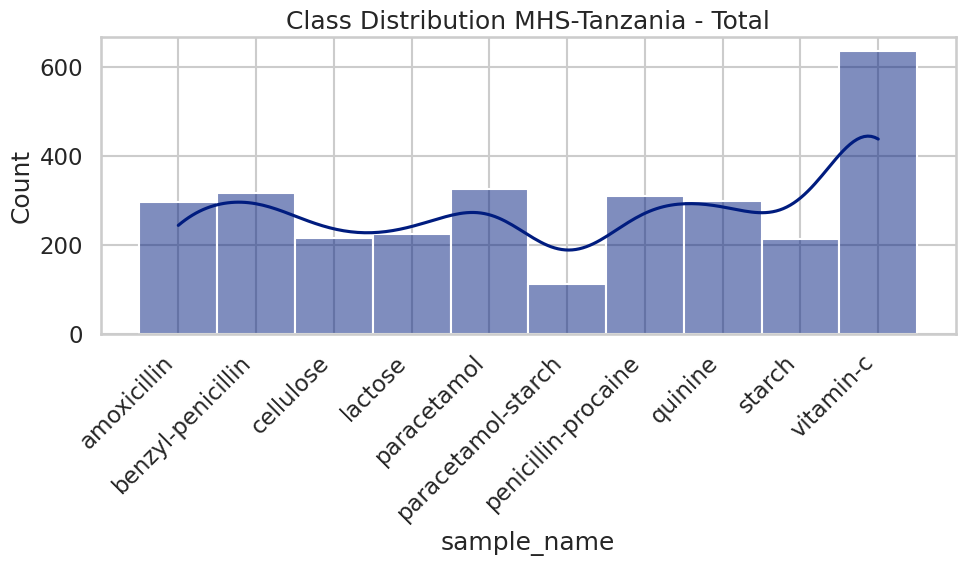

In [36]:

plot_sample_distribution(data, f"Class Distribution {DATASET_NAME} - Total")

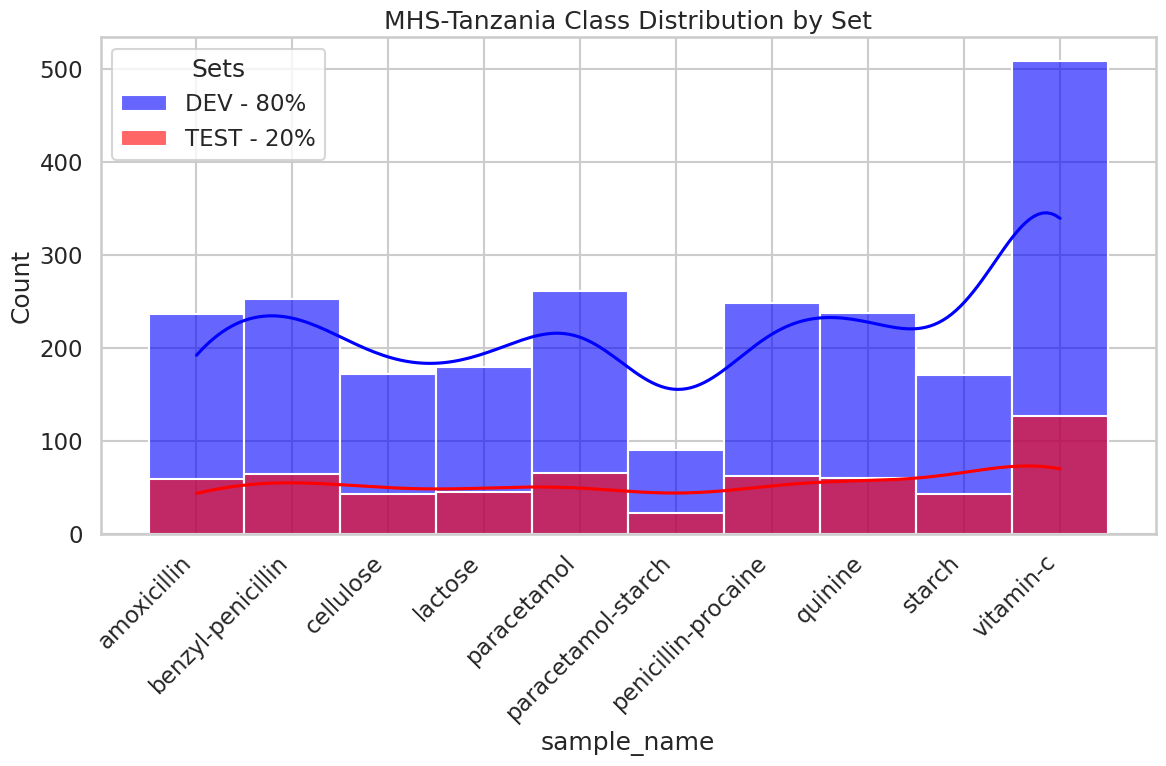

In [65]:
datasets = {f"DEV - {int((1- TEST_SPLIT_SIZE)*100)}%": dev_set, f"TEST - {int((TEST_SPLIT_SIZE)*100)}%": test_set}
plot_combined_sample_distribution(datasets, f"{DATASET_NAME} Class Distribution by Set", f"{REPORT_DIR}/class_distribution_combined.png")

### <a id='toc1_7_3_'></a>[Sanity Check](#toc0_)

> Is there any intersection between the sets?

In [39]:
dev_set.id.isin(test_set.id).sum()

0

## <a id='toc1_8_'></a>[Saving images to the fine dataset folder](#toc0_)

In [41]:
# copy images to the final dataset folder

# copy 'dev images' from source to destination_dev
copy_images(dev_set.image_name.to_list(), EXP_IMG_DIR, DEV_IMG_DIR)

# copy 'test images' from source to destination_test
copy_images(test_set.image_name.to_list(), EXP_IMG_DIR, TEST_IMG_DIR)

## <a id='toc1_9_'></a>[Persist the data and info with DVC](#toc0_)


```bash

 dvc add datasets/MHS-Tanzania/
 dvc push 

 git commit -m "add MHS-Tanzania Dataset to dvc"
 git push

```